# Anomaly Detection
In this notebook, we'll implement the anomaly detection algorithm, and use it on two sample datasets from the course graded lab.  
The code here are based on my own implementations in the graded lab, organized and rewritten to be more succinct and clear.

## Tools

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Dataset

### Problem Statement

In this exercise, you will implement an anomaly detection algorithm to
detect anomalous behavior in server computers.

The dataset contains two features - 
   * throughput (mb/s) and 
   * latency (ms) of response of each server.

While your servers were operating, you collected $m=307$ examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)}, \ldots, x^{(m)}\}$. 
* You suspect that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your
dataset. 

### Dataset

In [75]:
# Load the dataset
X_train = np.load('./data_anomaly/X_part1.npy')
X_val =  np.load('./data_anomaly/X_val_part1.npy')
y_val = np.load('./data_anomaly/y_val_part1.npy')

In [76]:
# Display the first five elements of X_train
print("The first 5 elements of X_train are:\n", X_train[:5])  

The first 5 elements of X_train are:
 [[13.04681517 14.74115241]
 [13.40852019 13.7632696 ]
 [14.19591481 15.85318113]
 [14.91470077 16.17425987]
 [13.57669961 14.04284944]]


In [77]:
# Display the first five elements of X_val
print("The first 5 elements of X_val are\n", X_val[:5])  

The first 5 elements of X_val are
 [[15.79025979 14.9210243 ]
 [13.63961877 15.32995521]
 [14.86589943 16.47386514]
 [13.58467605 13.98930611]
 [13.46404167 15.63533011]]


In [78]:
# Display the first five elements of y_val
print("The first 5 elements of y_val are\n", y_val[:5]) 

The first 5 elements of y_val are
 [0 0 0 0 0]


In [79]:
print ('The shape of X_train is:', X_train.shape)
print ('The shape of X_val is:', X_val.shape)
print ('The shape of y_val is: ', y_val.shape)

The shape of X_train is: (307, 2)
The shape of X_val is: (307, 2)
The shape of y_val is:  (307,)


### Visualize the data

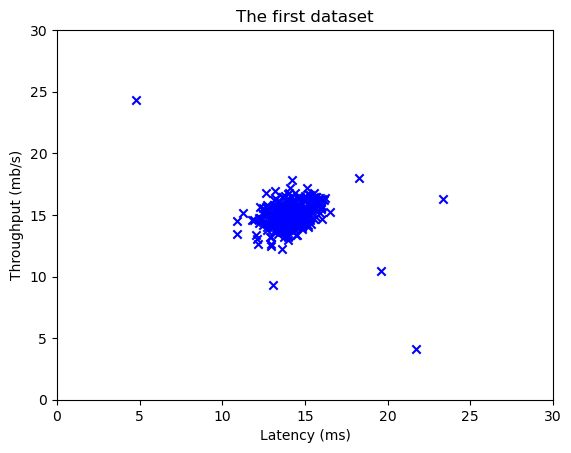

In [80]:
# Create a scatter plot of the data. To change the markers to blue "x",
# we used the 'marker' and 'c' parameters
plt.scatter(X_train[:, 0], X_train[:, 1], marker='x', c='b') 

# Set the title
plt.title("The first dataset")
# Set the y-axis label
plt.ylabel('Throughput (mb/s)')
# Set the x-axis label
plt.xlabel('Latency (ms)')
# Set axis range
plt.axis([0, 30, 0, 30])
plt.show()

## Implementation

We need to estimate the probability density of each training example:

$$
p(\vec{x}) = \prod_{i=1}^{n} p(x_j;\mu_j, \sigma_j^2) = 
\prod_{i=1}^{n} \frac{1}{\sqrt{2\pi} \sigma_j} exp(-\frac{(x_j-\mu_j)^2}{2\sigma_j^2})
$$

We'll implement with the following function:
- `estimate_gaussian`: calculate the mean and variance of each feature in the dataset
- `multivariate_gaussian`: calculate the multivariate gaussian probabibilty density of each example in the dataset

In [81]:
def estimate_gaussian(X): 
    """
    Calculates mean and variance of all features 
    in the dataset
    
    Args:
        X (ndarray): (m, n) Data matrix
    
    Returns:
        mu (ndarray): (n,) Mean of all features
        var (ndarray): (n,) Variance of all features
    """
    mu = np.mean(X, axis=0)
    var = np.var(X, axis=0)    
        
    return mu, var

In [82]:
def multivariate_gaussian(X, mu, var):
    """
    Calculates the multivariate gaussian of each example 
    in the dataset
    
    Args:
        X (ndarray): (m, n) Data matrix
        mu (ndarray): (n,) Mean of all features
        var (ndarray): (n,) Variance of all features
    Returns:
        p (ndarray): (m, ) probability of each example in the dataset
    """
    p = np.prod(np.exp(- (X - mu) ** 2 / (2 * var)) / np.sqrt(2 * np.pi * var), axis=1)
                
    return p

In [83]:
# Estimate mean and variance of each feature
mu, var = estimate_gaussian(X_train)              

print("Mean of each feature:", mu)
print("Variance of each feature:", var)

Mean of each feature: [14.11222578 14.99771051]
Variance of each feature: [1.83263141 1.70974533]


**Expected Output**:
<table>
  <tr>
    <td> <b>Mean of each feature: <b>  </td> 
    <td> [14.11222578 14.99771051]</td> 
   </tr>    
   <tr>
    <td> <b>Variance of each feature: <b>  </td>
     <td> [1.83263141 1.70974533] </td> 
  </tr>
</table>

In [84]:
# Returns the density of the multivariate normal
# at each data point (row) of X_train
p = multivariate_gaussian(X_train, mu, var)

### Algorithm evaluation
We'll fit the model $p(\vec{x})$ on the cross-validation set $X_{cv}$ and predict $y=1$ (anomaly) if $p(\vec{x})<\varepsilon$, $y=0$ (normal) if $p(\vec{x})\ge\varepsilon$.

To evaluate the algorithm and find the best value for $\varepsilon$, we'll use the F-1 score as our evaluatio metric. Recall that the precision, recall and F-1 score are defined as:

$$\begin{aligned}
   prec&=&\frac{tp}{tp+fp}\\
   rec&=&\frac{tp}{tp+fn}\\
   F_1 &=& \frac{2\cdot prec \cdot rec}{prec + rec}
\end{aligned}$$ 

We'll implement this with the following function:
- `select_threshold`: select the threshold value $\varepsilon$ by F-1 score

In [85]:
def select_threshold(y_val, p_val): 
    """
    Finds the best threshold to use for selecting outliers 
    based on the results from a validation set (p_val) 
    and the ground truth (y_val)
    
    Args:
        y_val (ndarray): Ground truth on validation set
        p_val (ndarray): Results on validation set
        
    Returns:
        epsilon (float): Threshold chosen 
        F1 (float):      F1 score by choosing epsilon as threshold
    """ 

    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
    
        y_hat = (p_val < epsilon).astype(int)
        tp = np.sum(np.logical_and(y_hat == y_val, y_hat == 1))
        fp = np.sum(np.logical_and(y_hat != y_val, y_hat == 1))
        fn = np.sum(np.logical_and(y_hat != y_val, y_hat == 0))   
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        F1 = 2 * prec * rec / (prec + rec)
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

In [86]:
p_val = multivariate_gaussian(X_val, mu, var)
epsilon, F1 = select_threshold(y_val, p_val)

print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)

Best epsilon found using cross-validation: 8.990853e-05
Best F1 on Cross Validation Set: 0.875000


**Expected Output**:
<table>
  <tr>
    <td> <b>Best epsilon found using cross-validation: <b>  </td> 
    <td> 8.99e-05</td> 
   </tr>    
   <tr>
    <td> <b>Best F1 on Cross Validation Set: <b>  </td>
     <td> 0.875 </td> 
  </tr>
</table>

## Find anomalies in the training set
We've found the best threshold value, now we'll find the anomalies with our selected threshold value, and visualize the anomalies with red circles on the plot.

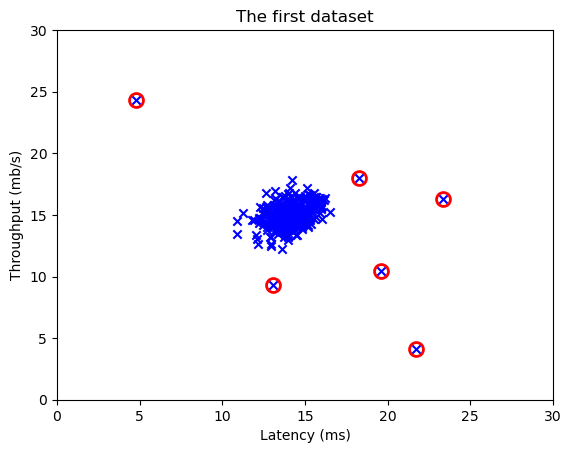

In [87]:
# Find the outliers in the training set 
outliers = p < epsilon

# Visualize the fit
plt.scatter(X_train[:, 0], X_train[:, 1], marker='x', c='b') 

# Set the title
plt.title("The first dataset")
# Set the y-axis label
plt.ylabel('Throughput (mb/s)')
# Set the x-axis label
plt.xlabel('Latency (ms)')
# Set axis range
plt.axis([0, 30, 0, 30])

# Draw a red circle around those outliers
plt.plot(X_train[outliers, 0], X_train[outliers, 1], 'ro',
         markersize= 10,markerfacecolor='none', markeredgewidth=2)
plt.show()

### High dimensional dataset

Now,  we will run the anomaly detection algorithm on a more realistic dataset with 11 features for each example.

Let's start by loading the dataset.

In [88]:
# Load the dataset
X_train_high = np.load('./data_anomaly/X_part2.npy')
X_val_high =  np.load('./data_anomaly/X_val_part2.npy')
y_val_high = np.load('./data_anomaly/y_val_part2.npy')

In [89]:
print ('The shape of X_train_high is:', X_train_high.shape)
print ('The shape of X_val_high is:', X_val_high.shape)
print ('The shape of y_val_high is: ', y_val_high.shape)

The shape of X_train_high is: (1000, 11)
The shape of X_val_high is: (100, 11)
The shape of y_val_high is:  (100,)


Now let's run the above algorithm on this larger dataset.

In [90]:
# Apply the same steps to the larger dataset

# Estimate the Gaussian parameters
mu_high, var_high = estimate_gaussian(X_train_high)

# Evaluate the probabilites for the training set
p_high = multivariate_gaussian(X_train_high, mu_high, var_high)

# Evaluate the probabilites for the cross validation set
p_val_high = multivariate_gaussian(X_val_high, mu_high, var_high)

# Find the best threshold
epsilon_high, F1_high = select_threshold(y_val_high, p_val_high)

print('Best epsilon found using cross-validation: %e'% epsilon_high)
print('Best F1 on Cross Validation Set:  %f'% F1_high)
print('# Anomalies found: %d'% sum(p_high < epsilon_high))

Best epsilon found using cross-validation: 1.377229e-18
Best F1 on Cross Validation Set:  0.615385
# Anomalies found: 117


**Expected Output**:
<table>
  <tr>
    <td> <b>Best epsilon found using cross-validation: <b>  </td> 
    <td> 1.38e-18</td> 
   </tr>    
   <tr>
    <td> <b>Best F1 on Cross Validation Set: <b>  </td>
     <td> 0.615385 </td> 
  </tr>
    <tr>
    <td> <b># anomalies found: <b>  </td>
     <td>  117 </td> 
  </tr>
</table>